In [ ]:
# my model base on lightGBM, I built two models: one for revenue, one for cost
# then EGM = 1 - cost/revenue

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

In [3]:
# load
data = pd.read_csv('df_egm.csv', parse_dates=['order_date'])
# feature with no variance / duplicated feature
data.drop(['store_id', 'is_liquidation', 'is_cancelled'], axis = 1, inplace = True)
# duplicated
data = data[~data['id'].duplicated()]
# drop cancelled
data = data[data['quantity_cancelled'] == 0]

data['date'] = data['order_date'].dt.date
data['cost'] = data['cost_product'] + data['cost_shipping'] + data['cost_other']

In [4]:
ds_egm = data[['id', 'date','revenue_net', 'cost']].copy()
ds_egm['egm'] = 1 - ds_egm['cost']/ds_egm['revenue_net']
# exluding revenue_net = 0: can't calculate EGM
ds_egm.loc[ds_egm['revenue_net'] == 0, 'egm'] = np.nan

In [5]:
in_mask = ds_egm['egm'].abs()<=3
out_mask = ds_egm['egm'].abs()>3
nan_mask = ds_egm['egm'].isnull()
ntotal = ds_egm.shape[0]

In [6]:
print('total_used:')
print(in_mask.sum()/ntotal)
print('\ntotal_used (no NaN):')
print(in_mask.sum()/(ntotal-nan_mask.sum()))

total_used:
0.9495986646016417

total_used (no NaN):
0.9892794970722577


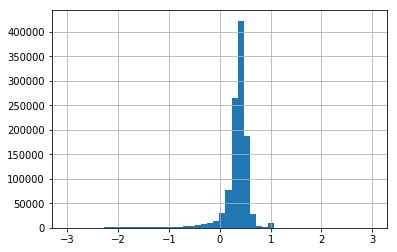

In [7]:
ds_egm.loc[in_mask, 'egm'].hist(bins = 50)

In [8]:
total_rev = ds_egm['revenue_net'].sum()
total_cos = ds_egm['cost'].sum()
in_rev = ds_egm.loc[in_mask, 'revenue_net'].sum()
out_rev = ds_egm.loc[out_mask, 'revenue_net'].sum()
in_cos = ds_egm.loc[in_mask, 'cost'].sum()
out_cos = ds_egm.loc[out_mask, 'cost'].sum()
nan_cos = ds_egm.loc[nan_mask, 'cost'].sum()

In [9]:
print('out_rev / total_rev:')
print(out_rev/total_rev)
print('\nout_cost / total_cost:')
print(out_cos/total_cos)
print('\nnan_cost / total_cost:')
print(nan_cos/total_cos)

out_rev / total_rev:
0.0010823211078405271

out_cost / total_cost:
0.012811353573652639

nan_cost / total_cost:
0.04536196886902122


In [10]:
data = data[in_mask]

In [11]:
### revenue model ###
# var_name to predict
rev_name = 'revenue_net'
# continuous features
rev_conts = ['date', 'sale_price', 'revenue_product', 'revenue_shipping', 'quantity_initial', 'revenue_net']
# categorical features
rev_cats = ['shipping_speed_id', 'supplier_id', 'category_id', 'class_id', 'carrier_id', 'manufacturer_id', 'is_b2b', 'is_giftcard']

In [12]:
def prep_data(data, conts, cats, y_name):
    # continuous features
    ds = data[conts].copy()
    # categorical features: code to 0 - (n-1)
    for cat in cats:
        ds[cat] = LabelEncoder().fit_transform(data[cat].copy())
        ds.loc[data[cat].isnull(), cat] = np.nan
    
    # time
    ds['month'] = data['order_date'].dt.month.copy() - 1
    ds['dom'] = data['order_date'].dt.day.copy() - 1
    ds['dow'] = data['order_date'].dt.dayofweek.copy()
    cats.extend(['month', 'dow'])
    
    # train/val/test split
    ds_train = ds[ds['date'] < date(2018, 6, 17)].copy()
    ds_val = ds[(ds['date'] >= date(2018, 6, 17)) & (ds['date'] <= date(2018, 7, 16))].copy()
    ds_test = ds[ds['date'] > date(2018, 7, 16)].copy()
    ds_train.drop('date', axis = 1, inplace = True)
    ds_val.drop('date', axis = 1, inplace = True)
    ds_test.drop('date', axis = 1, inplace = True)
    
    # X/y split
    X_train = ds_train.drop(y_name, axis = 1)
    y_train = ds_train[y_name]
    
    X_val = ds_val.drop(y_name, axis = 1)
    y_val = ds_val[y_name]
    
    X_test = ds_test.drop(y_name, axis = 1)
    y_test = ds_test[y_name]
    
    return X_train, X_val, X_test, y_train, y_val, y_test, cats

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test, cats = prep_data(data, rev_conts, rev_cats, rev_name)
rev_test = y_test
rev_train = y_train
X_rev_train = X_train

In [14]:
# set params
feat = X_train.columns.tolist()
params = {
    'num_leaves': 31,
    'objective': 'regression',
    'min_data_in_leaf': 600,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l1',
    'num_threads': 4
}

MAX_ROUNDS = 800
dtrain = lgb.Dataset(X_train, label = y_train, categorical_feature=cats)
dval = lgb.Dataset(X_val, label = y_val, reference=dtrain, categorical_feature=cats)

In [15]:
# train revenue model
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, valid_sets=[dtrain, dval],
                    early_stopping_rounds=50, verbose_eval=50)

/home/bearsun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/bearsun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l1: 22.6298	valid_1's l1: 22.6105
[100]	training's l1: 14.6379	valid_1's l1: 14.7515
[150]	training's l1: 14.4864	valid_1's l1: 14.7786
Early stopping, best iteration is:
[118]	training's l1: 14.537	valid_1's l1: 14.7211


In [16]:
print('Feature_importance:')
print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))

Feature_importance:
revenue_product: 486244733905.00
sale_price: 130745684722.00
quantity_initial: 43161398166.00
revenue_shipping: 2071265504.00
supplier_id: 1309812384.00
shipping_speed_id: 900008732.00
class_id: 821820494.00
manufacturer_id: 480637488.00
is_b2b: 79290330.00
month: 57782894.00
dow: 13287279.00
carrier_id: 1866640.00
dom: 440444.00
category_id: 320396.00
is_giftcard: 0.00


In [17]:
rev_pred = bst.predict(X_test)
rev_train_pred = bst.predict(X_train)
mean_absolute_error(rev_test, rev_pred)

14.641095904454552

In [18]:
# cost model
cos_name = 'cost'
cos_conts = ['date', 'sale_price', 'wholesale_price', 'quantity_initial', 'shipping_pred', 'cost']
cos_cats = ['shipping_speed_id', 'supplier_id', 'category_id', 'class_id', 'carrier_id', 'manufacturer_id', 'is_b2b', 'is_giftcard']

In [19]:
X_train, X_val, X_test, y_train, y_val, y_test, cats = prep_data(data, cos_conts, cos_cats, cos_name)
cos_test = y_test
cos_train = y_train
X_cos_train = X_train

In [20]:
feat = X_train.columns.tolist()
params = {
    'num_leaves': 31,
    'objective': 'regression',
    'min_data_in_leaf': 600,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'metric': 'l1',
    'num_threads': 4,
    'categorical_feature': cats,
    'feature_name': feat
}

MAX_ROUNDS = 800
dtrain = lgb.Dataset(X_train, label = y_train, categorical_feature=cats)
dval = lgb.Dataset(X_val, label = y_val, reference=dtrain, categorical_feature=cats)

In [21]:
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, valid_sets=[dtrain, dval],
                    early_stopping_rounds=50, verbose_eval=50)

/home/bearsun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:721: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/home/bearsun/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:721: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 50 rounds.
[50]	training's l1: 24.1212	valid_1's l1: 23.9585
[100]	training's l1: 20.3223	valid_1's l1: 20.8196
[150]	training's l1: 20.1097	valid_1's l1: 20.8389
Early stopping, best iteration is:
[100]	training's l1: 20.3223	valid_1's l1: 20.8196


In [22]:
print('Feature_importance:')
print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))

Feature_importance:
wholesale_price: 172093033224.00
sale_price: 71096274810.00
quantity_initial: 69190329619.00
shipping_speed_id: 5753535222.00
supplier_id: 3299470647.00
class_id: 2376296385.00
shipping_pred: 917322962.00
manufacturer_id: 546830331.00
month: 89282075.00
is_b2b: 85178880.00
dow: 10964330.00
dom: 2079650.00
category_id: 0.00
carrier_id: 0.00
is_giftcard: 0.00


In [23]:
cos_pred = bst.predict(X_test)
cos_train_pred = bst.predict(X_train)
mean_absolute_error(cos_test, cos_pred)

21.063140865891633

In [24]:
egm_pred = 1-(cos_pred/rev_pred)

In [25]:
egm = 1-cos_test/rev_test

In [26]:
mean_absolute_error(egm.values, egm_pred)

0.12303783349974766

In [27]:
egm_train = 1-cos_train/rev_train
egm_train_pred = 1-(cos_train_pred/rev_train_pred)
mean_absolute_error(egm_train.values, egm_train_pred)

0.12366869097073081

In [ ]:
# model evaluation

In [35]:
cos = pd.DataFrame(data = {'pred': cos_pred, 'true': cos_test})
cos['pred-true'] = cos['pred'] - cos['true']
rev = pd.DataFrame(data = {'pred': rev_pred, 'true': rev_test})
rev['pred-true'] = rev['pred'] - rev['true']

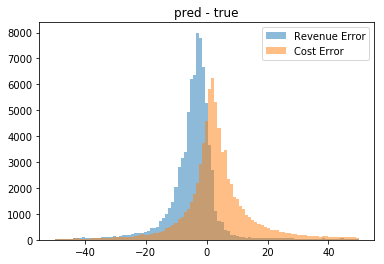

In [36]:
# error distributions of the two models
bins = np.linspace(-50, 50, 100)
plt.hist(rev.loc[rev['pred-true'].abs() < 50, 'pred-true'], bins, alpha=0.5, label='Revenue Error')
plt.hist(cos.loc[cos['pred-true'].abs() < 50, 'pred-true'], bins, alpha=0.5, label='Cost Error')
plt.legend(loc='upper right')
plt.title('pred - true')
plt.show()

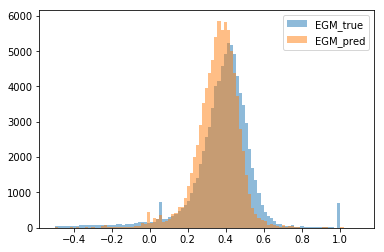

In [37]:
# EGM_true vs EGM_pred
bins = np.linspace(-.5, 1.1, 100)
plt.hist(egm.values, bins, alpha=0.5, label='EGM_true')
plt.hist(egm_pred, bins, alpha=0.5, label='EGM_pred')
plt.legend(loc='upper right')
plt.show()

0.015371503157547843

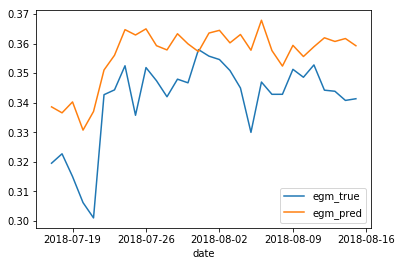

In [28]:
# egm_true / egm_pred by date (testing set)
egm_comp = egm.to_frame('egm_true')
egm_comp['egm_pred'] = egm_pred
egmbydate = egm_comp.join(ds_egm['date'])
mean_egm_date = egmbydate.groupby('date').mean()
mean_egm_date.plot()
mean_absolute_error(mean_egm_date['egm_true'], mean_egm_date['egm_pred'])

In [ ]:
####################### additional EDA

In [29]:
ds_egm = data[['id', 'date', 'order_date','revenue_net', 'cost', 'shipping_speed_id', 'supplier_id', 'category_id', 'class_id', 'carrier_id', 'manufacturer_id', 'is_b2b', 'is_giftcard', 'sale_price']].copy()
ds_egm['egm'] = 1 - ds_egm['cost']/ds_egm['revenue_net']

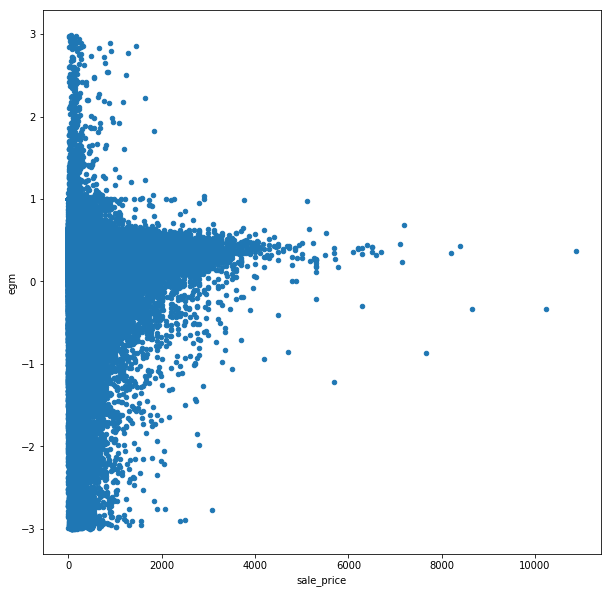

In [30]:
# egm / price
ds_egm[['sale_price', 'egm']].plot.scatter(x = 'sale_price', y = 'egm', figsize = [10,10])

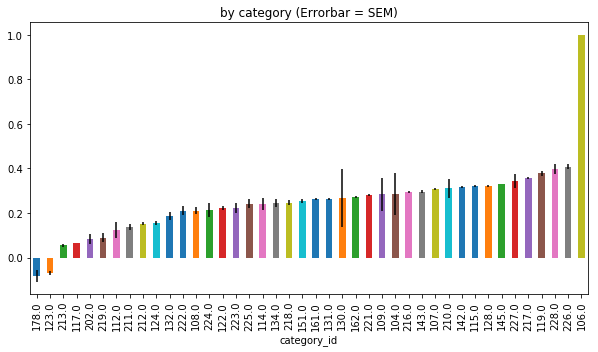

In [31]:
# bar by category
bycat = ds_egm.groupby('category_id')['egm'].mean().sort_values().to_frame().join(ds_egm.groupby('category_id')['egm'].sem().rename('sem'))
bycat.drop(154, inplace = True)
bycat['egm'].plot.bar(figsize = [10,5], title = 'by category (Errorbar = SEM)', yerr = bycat['sem'])

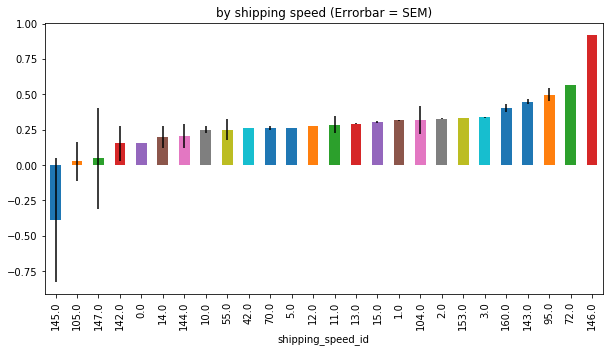

In [32]:
# bar by shipping speed
byspd = ds_egm.groupby('shipping_speed_id')['egm'].mean().sort_values().to_frame().join(ds_egm.groupby('shipping_speed_id')['egm'].sem().rename('sem')) 
byspd['egm'].plot.bar(figsize = [10,5], title = 'by shipping speed (Errorbar = SEM)', yerr = byspd['sem'])

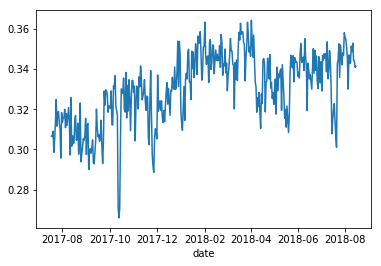

In [33]:
# egm by date (all data)
ds_egm.groupby('date')['egm'].mean().plot()

In [159]:
# egm by week of day, bootstrapping 95% CI
test = ds_egm[['dow', 'egm']]
boots = pd.DataFrame(columns = [0,1,2,3,4,5,6])
for i in range(500):
    boots = boots.append(test.sample(frac = 1, replace = True).groupby('dow').mean().transpose())

dow
0    0.329155
1    0.329428
2    0.330330
3    0.331793
4    0.321770
5    0.326440
6    0.327881
Name: egm, dtype: float64

Text(0.5,1,'Mon = 0, nboots = 500')

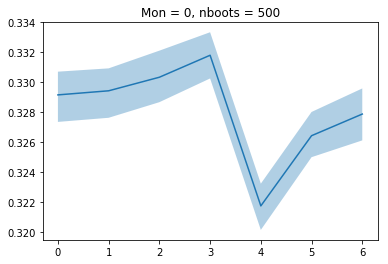

In [164]:
# egm by week of day
fig, ax = plt.subplots()
ax.plot(mdow.index.values, mdow.values)
ax.fill_between(mdow.index.values, boots.quantile(0.025).values, boots.quantile(0.975).values, alpha = .35)
plt.title('Mon = 0, nboots = 500')

In [169]:
# egm by day of month, bootstrap 95% CI
ds_egm['dom'] = ds_egm['order_date'].dt.day
mdom = ds_egm.groupby('dom')['egm'].mean()
test = ds_egm[['dom', 'egm']]
boots = pd.DataFrame(columns = list(range(1,32)))
for i in range(500):
    boots = boots.append(test.sample(frac = 1, replace = True).groupby('dom').mean().transpose())

Text(0.5,1,'Day of Month, nboots = 500')

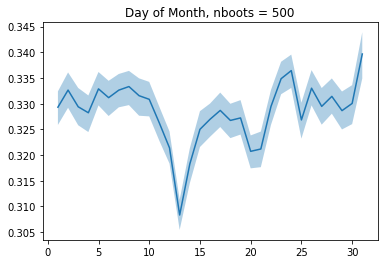

In [173]:
# egm by day of month
fig, ax = plt.subplots()
ax.plot(mdom.index.values, mdom.values)
ax.fill_between(mdom.index.values, boots.quantile(0.025).values, boots.quantile(0.975).values, alpha = .35)
plt.title('Day of Month, nboots = 500')